## Ablation Loss

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [3]:
from itertools import combinations
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [4]:
from collab_env.gnn.gnn import get_adjcency_from_debug, plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets, static_visualize_2sets

from collab_env.gnn.utility import dataset2testloader
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from itertools import product

In [5]:
torch.cuda.empty_cache()

In [6]:
data_names = ['boid_single_species_basic','boid_single_species_independent'] #'runpod/boid_single_species_basic']

data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'


### 1. with food

In [15]:
all_combinations = [
    #('boid_food_basic', 'vpluspplus_a', 0, 3, 0.5, 0),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, 0),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, 3),
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, 0),
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, 3),
]

### 2. without food

In [28]:
all_combinations = [
    #('boid_food_basic', 'vpluspplus_a', 0, 3, 0.5, 0),
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, 0),
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, 3),
    ('boid_single_species_independent', 'vpluspplus_a', 0.005, 1, 0.5, 3, 0),
    ('boid_single_species_independent', 'vpluspplus_a', 0.005, 1, 0.5, 3, 3),
]

In [29]:
rollout_results =  {}
data = {}
model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = True
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}_ablation'
    else:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_rollout5.pkl
0, Successfully import boid_
n0.005_h1_vr0.5_s2
ablation  3
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_zero_rollout5.pkl
1, Successfully import boid_
n0.005_h1_vr0.5_s2_ablation
ablation  0
/workspace/collab-environment/trained_models/runpod/boid_single_species_independent/rollouts/boid_single_species_independent_vpluspplus_a_n0.005_h1_vr0.5_s3_rollout5.pkl
2, Successfully import idpnt_
n0.005_h1_vr0.5_s3
ablation  3
/workspace/collab-environment/trained_models/runpod/boid_single_species_independent/rollouts/boid_single_species_independent_vpluspplus_a_n0.005_h1_vr0.5_s3_zero_rollout5.pkl
3, Successfully import idpnt_
n0.005_h1_vr0.5_s3_ablation


In [30]:
def sqr_diff(pred, actual):
    return np.sum((pred - actual) ** 2, axis = 2)

In [31]:
def return_mse(rollout_result, starting_frame, end_frame):
    
    F = len(rollout_result[0]['predicted']) #frames
    mse_by_frame = []
    std_by_frame = []
    for f in range(starting_frame, end_frame):
        Sqrdiff = []
        for b in [0,1]:#rollout_result:
            pred = rollout_result[b]['predicted'][f]
            actual = rollout_result[b]['actual'][f]
            Sqrdiff.append(sqr_diff(pred, actual))

        std_by_frame.append(np.std(np.concatenate(Sqrdiff, axis = 0)))
        mse_by_frame.append(np.mean(np.concatenate(Sqrdiff, axis = 0)))
    return np.array(mse_by_frame), np.array(std_by_frame)

In [32]:
import pandas as pd
import seaborn as sns

Text(0.5, 1.0, 'Independent dataset')

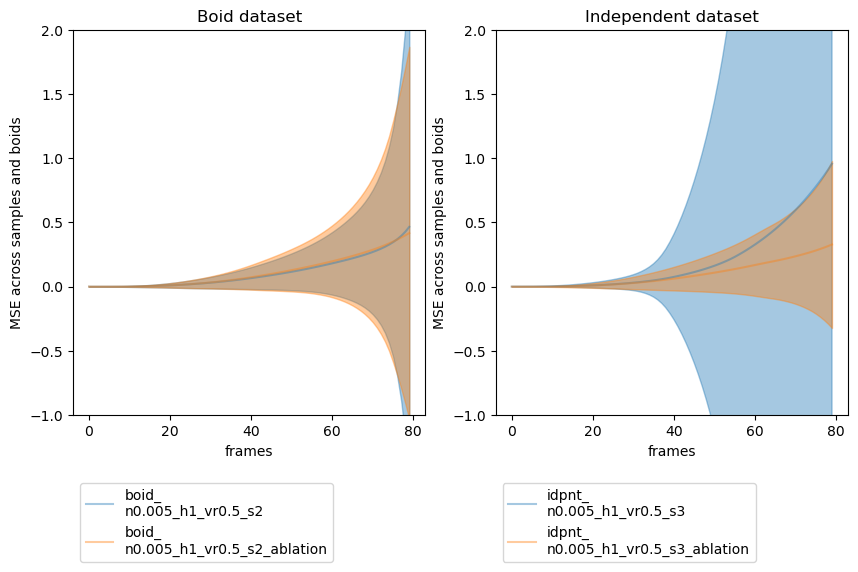

In [33]:
starting_frame = 0
end_frame = 80

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(10, 5))

mse_by_frame_all = []
mse_by_frame_all_dict = {} #fool-proof

for m in rollout_results:
    if "idpnt" in model_names[m]:
        ax = axes[1]
    else:
        ax = axes[0]
    if "ablation" in model_names[m]:
        c = 'C1'
    else:
        c = 'C0'
    mse_by_frame, std_by_frame = return_mse(rollout_results[m][0], starting_frame, end_frame)
    mse_by_frame_all.append(mse_by_frame)
    if mse_by_frame[60] <= 0.5:
        label = model_names[m]
    else:
        label = None
    ax.plot(mse_by_frame, label = label, alpha = 0.4, color = c)
    ax.fill_between(np.arange(len(mse_by_frame)), mse_by_frame - std_by_frame, mse_by_frame + std_by_frame,
                    alpha = 0.4, color = c)
    mse_by_frame_all_dict[m] = np.sum(mse_by_frame)

for ax in axes:
    ax.set_ylim([-1,2])
    ax.set_xlabel('frames')
    ax.set_ylabel('MSE across samples and boids')

axes[0].legend(bbox_to_anchor=(0, -0.4), loc='lower left')
axes[1].legend(bbox_to_anchor=(0, -0.4), loc='lower left')
axes[0].set_title("Boid dataset")
axes[1].set_title("Independent dataset")